In [ ]:
# Install Required Library

!pip install numpy==1.23.5
!pip install pandas==1.5.3
!pip install matplotlib==3.7.1
!pip install earthengine-api==0.1.374
!pip install scikit-learn==1.2.2
!pip install shapely==2.0.1
!pip install geopandas==0.13.2
!pip install geemap==0.28.2
!pip install seaborn==0.12.2
!pip install xgboost==2.0.0
!pip install tqdm==4.66.1
!pip install torch==2.0.1+cu118

In [1]:
# Basic Python Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Geospatial Library
import ee
import geemap
from shapely.geometry import Point
import geopandas as gpd

# Machine Learning Library
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import decomposition
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn import svm
import joblib

# Pytorch Deep Learning Library
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable

### Additional Library
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

<b> Use GEE Credential to login and download Satellite Data </b>

In [4]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=W0enaKx9xq5hiZZ6LIxu-QHNLlyeOqot-Sih65WV81E&tc=gMzZRPkX1eSm7tlI9FSBeA827AJYEfpSFi49Xaz76ho&cc=DPEB1Ip2sZI5dEpcYps8MZRDVlhrsI5SfkroXvDU2Ao

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXmydC5yJTUb7XlVhkCfNJ1G9XFixPMP_apeZR81pBJxDaGZXHgQ3Po

Successfully saved authorization token.


In [5]:
ee.Initialize()

In [6]:
# Change the path according to the file store in their own system
train_path = '/content/drive/MyDrive/Train.csv'
test_path = '/content/drive/MyDrive/Test.csv'

In [7]:
# Read CSV File using Pandas Library which convert into DataFrame
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [8]:
# Function to create a different Vegetation as well as Mositure/water Indices from Sentinel-2 Satellite Dataset.

def addIndices(image):

    # Normalized Difference Vegetation Index
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Normalized Difference Red-Edged Index
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')

    # Soil Adjusted Vegetation Index
    savi = ee.Image().expression('((NIR-RED)/(NIR+RED+0.5))*1.5',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000)}).rename('SAVI')

    #Atmospherically Resistant Vegetation Index
    arvi = ee.Image().expression('((NIR-2*RED + BLUE)/(NIR+2*RED+BLUE))',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000),
                                 'BLUE':image.select('B2').divide(10000)}).rename('ARVI')

    # Normalized Difference Mositure Index
    ndmi = ee.Image().expression('((NIR-SWIR)/(NIR+SWIR))',\
                                 {'NIR':image.select('B8'),
                                  'SWIR':image.select('B11')}).rename('NDMI')

    # Green Condition Index
    gci = ee.Image().expression('(NIR/GREEN) - 1',\
                                {'NIR':image.select('B8').divide(10000),
                                 'GREEN':image.select('B3').divide(10000)}).rename('GCI')

    # Red Vegetation Index
    rvi = ee.Image().expression('(NIR/RED)',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000)}).rename('RVI')

    #Optimized Soil Adjusted Vegetation Index
    osavi = ee.Image().expression('((NIR-RED)/(NIR+RED+0.16))*1.16',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000)}).rename('OSAVI')

    # Specific Leaf Area Vegetation Index
    slavi = ee.Image().expression('NIR/(RED+SWIR2)',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000),
                                 'SWIR2':image.select('B12').divide(10000)}).rename('SLAVI')

    # Normalized Pigment Chlorophyll Ration Index
    npcri = ee.Image().expression('((RED-BLUE)/(BLUE+RED))',\
                                {'BLUE':image.select('B2'),
                                 'RED':image.select('B4')}).rename('NPCRI')

    #Soil Condition Index
    sci = ee.Image().expression('((SWIR-NIR)/(SWIR+NIR))',\
                                {'NIR':image.select('B8'),
                                 'SWIR':image.select('B11')}).rename('SCI')

    # Normalized Difference Water Index
    ndwi = ee.Image().expression('((GREEN-NIR)/(GREEN+NIR))',\
                                 {'NIR':image.select('B8').divide(10000),
                                  'GREEN':image.select('B3').divide(10000)}).rename('NDWI')

    # Green Normalized Difference Vegetaion Index
    gndvi = ee.Image().expression('((NIR-GREEN)/(GREEN+NIR))',\
                                {'NIR':image.select('B8'),
                                 'GREEN':image.select('B3')}).rename('GNDVI')

    # Bare soil Index
    bsi = ee.Image().expression('((SWIR+RED)-(NIR+BLUE))/((SWIR+RED)+(NIR+BLUE))',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000),
                                 'BLUE':image.select('B2').divide(10000),
                                 'SWIR':image.select('B11').divide(10000)}).rename('BSI')

    # Enhanced Vegetation Index
    evi = ee.Image().expression('((2.5*(NIR-RED))/(NIR+6*RED-7.5*BLUE+1))',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000),
                                 'BLUE':image.select('B2').divide(10000)}).rename('EVI')


    return image.addBands(ndvi).addBands(ndre).addBands(savi).addBands(arvi).addBands(ndwi).addBands(gci).addBands(rvi).addBands(osavi).addBands(slavi).addBands(npcri).addBands(sci).addBands(ndmi).addBands(gndvi).addBands(bsi).addBands(evi)

*The training and test CSV files contain latitude and longitude coordinates, along with labels, except in the test file. These will be converted into a point shapefile, which will be utilized in the Google Earth Engine (GEE) as a labeled training dataset.*

In [9]:
def csv_to_geopandas(df):
    points = []
    for idx,row in df.iterrows():
        point = Point([row['Lon'],row['Lat']])
        points.append(point)

    gdf = gpd.GeoDataFrame(df,geometry=points)
    gdf = gdf.drop(columns=['Lat','Lon'])
    gdf.set_crs(epsg=4326,inplace=True)  # WGS84 Coordinate System
    return gdf

trainGDF = csv_to_geopandas(train)
testGDF = csv_to_geopandas(test)
trainGDF.head()

,ID,Target,geometry
0,ID_SJ098E7S2SY9,0,POINT (70.76367 34.16249)
1,ID_CWCD60FGJJYY,0,POINT (48.49205 32.07570)
2,ID_R1XF70RMVGL3,1,POINT (33.31348 14.54283)
3,ID_0ZBIDY0PEBVO,1,POINT (33.28411 14.35948)
4,ID_C20R2C0AYIT0,0,POINT (33.52845 14.41913)


0 : Non-Crop Label

1 : Crop Label

In [10]:
# Afghanistan Area of Interest (AOI)
aoi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")\
        .filter(ee.Filter.eq('ADM0_NAME','Afghanistan'))\
        .filter(ee.Filter.eq('ADM1_NAME','Nangarhar'));

In [11]:
# GEE Provide Sentinel-2 Dataset along with Cloud Probability Dataset which can mask the pixel on the basis of Threshold Probability

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
s2c = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

# Define dates over which to create a composite.
start = ee.Date('2022-03-01')
end = ee.Date('2022-06-01')

# Define a collection filtering function.
def filterBoundsDate(imgCol, aoi, start, end):
    return imgCol.filterBounds(aoi).filterDate(start, end)

# Filter the collection by AOI and date.
s2 = filterBoundsDate(s2, aoi, start, end)
s2c = filterBoundsDate(s2c, aoi, start, end)

# Define a function to join the two collections on their 'system:index'
# property. The 'propName' parameter is the name of the property that
# references the joined image.
def indexJoin(colA, colB, propName):
    joined = ee.ImageCollection(ee.Join.saveFirst(propName).apply(**{
        'primary': colA,
        'secondary': colB,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

    def func_mti(image):
        return image.addBands(ee.Image(image.get(propName)))

    return joined.map(func_mti)

# Define a function to create a cloud masking function.
def buildMaskFunction(img):
    cloudProb = 50
    # Define clouds as pixels having greater than the given cloud probability.
    cloud = img.select('probability').gt(ee.Image(cloudProb))

    # Apply the cloud mask to the image and return it.
    return img.updateMask(cloud.Not())

# Join the cloud probability collection to the TOA reflectance collection.
withCloudProbability = indexJoin(s2, s2c, 'cloud_probability')

# Map the cloud masking function over the joined collection, select only the
# reflectance bands.

s2collection = ee.ImageCollection(withCloudProbability.map(buildMaskFunction))

In [12]:
# Function to compute 15Day composites as Temporal Resolution of Sentinel-2 is 5-6 Day

def create_15_day_composites(collection):
    start_date = ee.Date('2022-03-01')
    end_date = ee.Date('2022-06-01')

    # Calculate the number of 15-day intervals between the start and end dates.
    n_half_months = end_date.difference(start_date, 'day').divide(15).round()
    half_month_range = ee.List.sequence(0, n_half_months.subtract(1))

    def compute_composite(m):
        m = ee.Number(m)
        start = start_date.advance(m.multiply(15), 'day')
        end = start.advance(15, 'day')
        year = start.get('year')
        month = start.get('month')
        day = start.get('day')

        half_monthly_composite = (collection.filterDate(start, end)
                                  .median()
                                  .set('system:time_start', start)
                                  .set('year', year)
                                  .set('month', month)
                                  .set('day', day))
        return half_monthly_composite

    composites = half_month_range.map(compute_composite)
    return ee.ImageCollection(composites)

In [13]:
s2MonthlyComposites = create_15_day_composites(s2collection).map(addIndices)

In [14]:
s2MonthlyComposites = s2MonthlyComposites.select(['NDVI','NDRE','SAVI', 'ARVI', 'NDWI', 'GCI', 'RVI',
                                    'OSAVI', 'SLAVI', 'NPCRI', 'SCI', 'NDMI', 'GNDVI', 'BSI', 'EVI'])

In [15]:
# ImageCollection to Single Image where Temporal Dataset of 15Day Composite Image goes to N Number Bands
combinedImage = s2MonthlyComposites.toBands()
print('BandName :',combinedImage.bandNames().getInfo())

BandName : ['0_NDVI', '0_NDRE', '0_SAVI', '0_ARVI', '0_NDWI', '0_GCI', '0_RVI', '0_OSAVI', '0_SLAVI', '0_NPCRI', '0_SCI', '0_NDMI', '0_GNDVI', '0_BSI', '0_EVI', '1_NDVI', '1_NDRE', '1_SAVI', '1_ARVI', '1_NDWI', '1_GCI', '1_RVI', '1_OSAVI', '1_SLAVI', '1_NPCRI', '1_SCI', '1_NDMI', '1_GNDVI', '1_BSI', '1_EVI', '2_NDVI', '2_NDRE', '2_SAVI', '2_ARVI', '2_NDWI', '2_GCI', '2_RVI', '2_OSAVI', '2_SLAVI', '2_NPCRI', '2_SCI', '2_NDMI', '2_GNDVI', '2_BSI', '2_EVI', '3_NDVI', '3_NDRE', '3_SAVI', '3_ARVI', '3_NDWI', '3_GCI', '3_RVI', '3_OSAVI', '3_SLAVI', '3_NPCRI', '3_SCI', '3_NDMI', '3_GNDVI', '3_BSI', '3_EVI', '4_NDVI', '4_NDRE', '4_SAVI', '4_ARVI', '4_NDWI', '4_GCI', '4_RVI', '4_OSAVI', '4_SLAVI', '4_NPCRI', '4_SCI', '4_NDMI', '4_GNDVI', '4_BSI', '4_EVI', '5_NDVI', '5_NDRE', '5_SAVI', '5_ARVI', '5_NDWI', '5_GCI', '5_RVI', '5_OSAVI', '5_SLAVI', '5_NPCRI', '5_SCI', '5_NDMI', '5_GNDVI', '5_BSI', '5_EVI']


Prefix Attached to Indices

- 0 : 1st 15Day Mar
- 1 : 2nd 15Day Mar  
- 0 : 1st 15Day Apr
- 1 : 2nd 15Day Apr 
- 0 : 1st 15Day May
- 1 : 2nd 15Day May 

In [16]:
# Shapefile conversion to GEE Feature and FeatureCollection

def geopandas_to_ee(gdf):
    features = []
    for idx, row in gdf.iterrows():
        geo = row['geometry']
        properties = row.drop('geometry').to_dict()
        features.append(ee.Feature(ee.Geometry(geo.__geo_interface__),properties))
    return ee.FeatureCollection(features)

trainEE = geopandas_to_ee(trainGDF)
testEE = geopandas_to_ee(testGDF)
#print(trainEE.first().getInfo())

In [17]:
# There are a total of 1500 sample points each in both the training and test datasets.
# To use only the Afghanistan Ground Truth sample points, employ the filterBounds technique
# to select sample points from the specified region.

trainEE = trainEE.filterBounds(aoi)
testEE = testEE.filterBounds(aoi)

In [18]:
# Extract Sentinel-2 Satellite Indices from a given location

def calculateMetrics(block):
    metrics = combinedImage.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': block.geometry(),
        'scale':10, # Spatial Resolution of Sentinel-2
     })
    return ee.Feature(None,metrics).copyProperties(block, ['ID','Target'])

trainEE = trainEE.map(calculateMetrics)
testEE = testEE.map(calculateMetrics)

*The steps below are to convert the Google Earth Engine (GEE) FeatureCollection into a Pandas DataFrame, which will subsequently be used for analysis and model development.*

In [19]:
train_samples,test_samples = [],[]

In [20]:
for item in trainEE.getInfo()['features']:
    train_samples.append(item['properties'])

In [21]:
for item in testEE.getInfo()['features']:
    test_samples.append(item['properties'])

In [22]:
train_samples_df = pd.DataFrame(train_samples)
test_samples_df = pd.DataFrame(test_samples)

In [23]:
train_samples_df.head()

,0_ARVI,0_BSI,0_EVI,0_GCI,0_GNDVI,0_NDMI,0_NDRE,0_NDVI,0_NDWI,0_NPCRI,...,5_NDVI,5_NDWI,5_NPCRI,5_OSAVI,5_RVI,5_SAVI,5_SCI,5_SLAVI,ID,Target
0,0.010189,0.160391,0.123538,0.588529,0.227360,-0.131117,0.063439,0.166266,-0.227360,0.217784,...,0.074355,-0.178527,0.255144,0.066170,1.160656,0.057243,0.144411,0.458846,ID_SJ098E7S2SY9,0
1,0.101329,0.075569,0.206321,0.950735,0.322203,-0.029893,0.142304,0.271203,-0.322203,0.171803,...,0.087919,-0.134161,0.155858,0.080402,1.192789,0.071715,0.062667,0.541416,ID_I5DS1NLN2WM8,1
2,0.017648,0.129232,0.142381,0.578962,0.224494,-0.078250,0.053514,0.181002,-0.224494,0.227104,...,0.113734,-0.177677,0.192648,0.103900,1.256659,0.092562,0.088777,0.526127,ID_JBRO8Z453K1J,1
3,-0.032160,0.161961,0.073689,0.406178,0.168806,-0.138526,0.031257,0.095365,-0.168806,0.201539,...,0.058686,-0.148766,0.231409,0.053708,1.124689,0.047946,0.120494,0.472855,ID_GYHRWRLEY9W3,0
4,-0.067364,0.136412,0.023024,0.187126,0.085558,-0.104017,-0.018438,0.026640,-0.085558,0.181467,...,0.023807,-0.092269,0.172629,0.021626,1.048776,0.019141,0.084250,0.476932,ID_LLW4ZVLCTH7Y,0


In [24]:
test_samples_df.head()

,0_ARVI,0_BSI,0_EVI,0_GCI,0_GNDVI,0_NDMI,0_NDRE,0_NDVI,0_NDWI,0_NPCRI,...,5_NDRE,5_NDVI,5_NDWI,5_NPCRI,5_OSAVI,5_RVI,5_SAVI,5_SCI,5_SLAVI,ID
0,0.026433,0.098148,0.124356,0.510552,0.203363,-0.066193,0.070494,0.157156,-0.203363,0.152283,...,0.344106,0.487200,-0.465465,0.196492,0.426507,2.900158,0.362528,-0.135060,1.103074,ID_9ZLHTVF6NSU7
1,0.025754,0.055659,0.147475,0.586271,0.226686,0.019571,0.186732,0.169440,-0.226686,0.178048,...,0.249657,0.198172,-0.246937,0.160112,0.184226,1.494302,0.167525,-0.047813,0.706936,ID_B2WO8GOJOMY1
2,0.441122,-0.079041,0.448985,2.740550,0.578108,0.141484,0.399700,0.637868,-0.578108,0.223729,...,0.033912,0.106684,-0.214772,0.274795,0.091389,1.238850,0.075961,0.159099,0.461595,ID_K82JJ5PQCMXM
3,0.364233,-0.030519,0.370170,2.727331,0.576928,0.103580,0.345092,0.578002,-0.576928,0.288446,...,0.190694,0.241808,-0.343806,0.345602,0.210614,1.637856,0.178070,0.066272,0.641938,ID_5LACW9CE2OIB
4,-0.051359,0.124432,0.055211,0.273242,0.120199,-0.079620,0.027900,0.058023,-0.120199,0.189481,...,0.027788,0.049219,-0.110938,0.153379,0.046201,1.103534,0.042508,0.062418,0.513783,ID_O6RIQWT1103E


*Save the pandas dataframe to csv file*

In [25]:
#train_samples_df.to_csv('AfghanTraining_15D.csv',index=False)
#test_samples_df.to_csv('AfghanTesting_15D.csv',index=False)

  **Model Development**

In [26]:
# Reproducible  Results
import random

seed = 2023

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [27]:
# Availablility of GPU device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [28]:
# Conversion of Pandas Dataframe to required Pytorch Dataset

class TimeSeries(Dataset):
    def __init__(self,df,features,Target):
        self.df = df
        self.features = features
        self.Target = Target
        self.X,self.y = self.make_sequence()
    def make_sequence(self):
        X = []
        y = []
        for i in range(len(self.df)):
            X.append(self.df.loc[i,self.features].astype(float).values.reshape(6,6))
            y.append(self.df.loc[i,self.Target])
        return torch.tensor(X).float(),torch.tensor(y).float()
    def __len__(self):
        return len(self.X)

    def __getitem__(self,ix):
        return self.X[ix],self.y[ix]

In [29]:
# Selected and Important Indices for Afghanistan Region

features = ['0_NDVI','0_NDRE','0_GNDVI','0_ARVI','0_NDMI','0_BSI',
         '1_NDVI','1_NDRE','1_GNDVI','1_ARVI','1_NDMI','1_BSI',
         '2_NDVI','2_NDRE','2_GNDVI','2_ARVI','2_NDMI','2_BSI',
         '3_NDVI','3_NDRE','3_GNDVI','3_ARVI','3_NDMI','3_BSI',
         '4_NDVI','4_NDRE','4_GNDVI','4_ARVI','4_NDMI','4_BSI',
         '5_NDVI','5_NDRE','5_GNDVI','5_ARVI','5_NDMI','5_BSI']
Target = 'Target'

In [32]:
# Splitting of Training Dataset into Train and Validation where Validation helps to improve the model hyperparamter and early stopping
test_size = 0.3
X = train_samples_df.drop(['Target'],axis=1)
y = train_samples_df[['Target']]

trainX,valX,trainY,valY = model_selection.train_test_split(X,y,test_size=test_size,random_state=seed,stratify=y)

trainDF = pd.concat([trainX,trainY],axis=1)
valDF = pd.concat([valX,valY],axis=1)

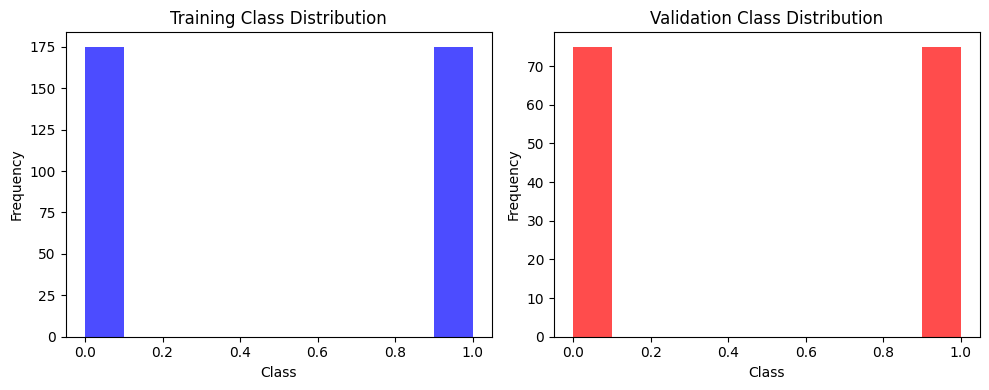

In [34]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
# Plot the first histogram on the left subplot
axs[0].hist(trainY, color='blue', alpha=0.7)
axs[0].set_title("Training Class Distribution")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Frequency")

# Plot the second histogram on the right subplot
axs[1].hist(valY, color='red', alpha=0.7)
axs[1].set_title("Validation Class Distribution")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Frequency")

# Display the plots
plt.tight_layout()
plt.show()

In [35]:
trainDF.reset_index(drop=True,inplace=True)
valDF.reset_index(drop=True,inplace=True)

# Deep Learning Format Dataset
trainDS = TimeSeries(trainDF,features,Target)
valDS = TimeSeries(valDF,features,Target)

In [36]:
# DataLoader Module to Convert the Dataset, so as to send the data into batches
trainDL = DataLoader(trainDS,batch_size=14,shuffle=False)
valDL = DataLoader(valDS,batch_size=1,shuffle=False)

<i> Bi-Directional LSTM </i>

> Bi-directional Long Short-Term Memory (Bi-LSTM) models belong to the family of recurrent neural networks (RNNs) and are specifically designed to capture sequential information by processing data in both forward and backward directions. By considering both past and future contexts simultaneously, Bi-LSTMs are able to make more informed predictions, especially in tasks that involve sequences, such as time-series forecasting, natural language processing, and speech recognition.



In [37]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(BiLSTMClassifier, self).__init__()

        self.hidden_size = hidden_size
        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate, bidirectional=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(2*hidden_size, 2)  # 2*hidden_size because it's bidirectional

        # Softmax layer for converting output to probability
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Passing input through LSTM layer
        lstm_out, _ = self.lstm(x)

        # Taking the last output of LSTM (using the forward and backward hidden states)
        final_hidden_state = torch.cat((lstm_out[:, -1, :self.hidden_size],
                                        lstm_out[:, 0, self.hidden_size:]), dim=1)

        # Passing LSTM output through fully connected layer
        fc_out = self.fc(final_hidden_state)

        # Passing through softmax layer to get probabilities
        output = self.softmax(fc_out)
        return output

In [38]:
model = BiLSTMClassifier(input_size=6, hidden_size=50, num_layers=1, dropout_rate=0.42)

In [39]:
# Shape of the Final Output from the model
model(torch.randn(1,6,6)).shape

torch.Size([1, 2])

In [40]:
# Diffuse the model to GPU, as it train faster.
model = model.to(device)

In [41]:
# Negative Log-Likelihood Loss which is commonly used for classifying a model that estimates class probabailities,
# such that predicted probability of true class should be maximized.
criterion = nn.NLLLoss()

# In neural networks, an optimizer is an algorithm used to minimize (or maximize) the loss function by
# iteratively adjusting the model's weights and biases.
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
train_losses,val_losses = [],[]

In [45]:
def running_model(model,train_data,valid_data,n_epochs):
    best_loss = float('inf')
    for epoch in tqdm(range(1,n_epochs+1)):
        train_loss = 0.0
        val_loss = []

        for i,(inputs,labels) in enumerate(train_data):
            model.train()

            inputs = Variable(inputs).to(device)
            labels = Variable(labels.type(torch.LongTensor)).to(device)
            outputs = model(inputs)

            loss = criterion(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += round(loss.cpu().item(),5)*inputs.size(0)

            if i%10 == 0 and i>0:
                model.eval()
                with torch.no_grad():
                    eval_loss = 0.0
                    for inputs,labels in valid_data:
                        inputs = Variable(inputs).to(device)
                        labels = Variable(labels.type(torch.LongTensor)).to(device)

                        outputs = model(inputs)

                        eval_loss += round(criterion(outputs,labels).cpu().item(),5)*inputs.size(0)
                    val_loss.append(eval_loss/len(valid_data.dataset))

        overall_val_loss=sum(val_loss)/len(val_loss)
        print(f'{epoch} Epoch is completed and their validation loss is {overall_val_loss}')
        if overall_val_loss<best_loss:
            best_loss=overall_val_loss
            torch.save(model.state_dict(),f'/content/drive/MyDrive/model_optuna{epoch}.pth') # Path to save a model

        train_losses.append(train_loss / len(train_data.dataset))
        val_losses.append(overall_val_loss)

In [46]:
running_model(model,trainDL,valDL,60)

  0%|          | 0/60 [00:00<?, ?it/s]

1 Epoch is completed and their validation loss is 0.6333369666666666
2 Epoch is completed and their validation loss is 0.6339327000000001
3 Epoch is completed and their validation loss is 0.6078702666666669
4 Epoch is completed and their validation loss is 0.5874175666666663
5 Epoch is completed and their validation loss is 0.5768146666666664
6 Epoch is completed and their validation loss is 0.5686707333333333
7 Epoch is completed and their validation loss is 0.5626114666666666
8 Epoch is completed and their validation loss is 0.5567005666666666
9 Epoch is completed and their validation loss is 0.5494869666666666
10 Epoch is completed and their validation loss is 0.5391218999999998
11 Epoch is completed and their validation loss is 0.5238586666666666
12 Epoch is completed and their validation loss is 0.5052399333333335
13 Epoch is completed and their validation loss is 0.4935561999999998
14 Epoch is completed and their validation loss is 0.4912300999999999
15 Epoch is completed and the